In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_roi_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 276)
(734160, 1)
validation
(101248, 276)
(101248, 1)
test
(100432, 276)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 972801 (3.71 MB)


Trainable params: 972801 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:22 - loss: 0.1963 - STD: 7.6615e-05 - MAE: 0.4308

 6/74 [=>............................] - ETA: 0s - loss: 0.0586 - STD: 1.6854e-04 - MAE: 0.1872  

11/74 [===>..........................] - ETA: 0s - loss: 0.0506 - STD: 1.0639e-04 - MAE: 0.1798

16/74 [=====>........................] - ETA: 0s - loss: 0.0425 - STD: 7.7891e-05 - MAE: 0.1583

21/74 [=======>......................] - ETA: 0s - loss: 0.0358 - STD: 6.4209e-05 - MAE: 0.1417

26/74 [=========>....................] - ETA: 0s - loss: 0.0321 - STD: 5.6478e-05 - MAE: 0.1361

31/74 [===========>..................] - ETA: 0s - loss: 0.0289 - STD: 5.1388e-05 - MAE: 0.1252

36/74 [=============>................] - ETA: 0s - loss: 0.0268 - STD: 4.8078e-05 - MAE: 0.1163

41/74 [===============>..............] - ETA: 0s - loss: 0.0250 - STD: 4.6269e-05 - MAE: 0.1099

46/74 [=================>............] - ETA: 0s - loss: 0.0237 - STD: 4.5455e-05 - MAE: 0.1068

51/74 [===================>..........] - ETA: 0s - loss: 0.0225 - STD: 4.5177e-05 - MAE: 0.1038

56/74 [=====================>........] - ETA: 0s - loss: 0.0216 - STD: 4.5287e-05 - MAE: 0.1003

61/74 [=======================>......] - ETA: 0s - loss: 0.0208 - STD: 4.5851e-05 - MAE: 0.0974

66/74 [=========================>....] - ETA: 0s - loss: 0.0203 - STD: 4.6889e-05 - MAE: 0.0955

71/74 [===========================>..] - ETA: 0s - loss: 0.0197 - STD: 4.8272e-05 - MAE: 0.0939

74/74 [==============================] - 3s 26ms/step - loss: 0.0194 - STD: 4.9261e-05 - MAE: 0.0929 - val_loss: 0.0146 - val_STD: 6.0478e-05 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0125 - STD: 7.6552e-05 - MAE: 0.0679

 6/74 [=>............................] - ETA: 0s - loss: 0.0121 - STD: 7.9847e-05 - MAE: 0.0673

11/74 [===>..........................] - ETA: 0s - loss: 0.0120 - STD: 8.4340e-05 - MAE: 0.0684

16/74 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 8.9224e-05 - MAE: 0.0689

21/74 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 9.4694e-05 - MAE: 0.0690

26/74 [=========>....................] - ETA: 0s - loss: 0.0121 - STD: 1.0063e-04 - MAE: 0.0691

31/74 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 1.0713e-04 - MAE: 0.0692

36/74 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 1.1423e-04 - MAE: 0.0692

41/74 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 1.2205e-04 - MAE: 0.0691

46/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 1.3100e-04 - MAE: 0.0691

52/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 1.4333e-04 - MAE: 0.0692

57/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 1.5486e-04 - MAE: 0.0691

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 1.6800e-04 - MAE: 0.0691

67/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 1.8301e-04 - MAE: 0.0690

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 2.0047e-04 - MAE: 0.0690

74/74 [==============================] - 1s 12ms/step - loss: 0.0120 - STD: 2.0809e-04 - MAE: 0.0690 - val_loss: 0.0144 - val_STD: 4.1497e-04 - val_MAE: 0.0733


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0119 - STD: 5.0261e-04 - MAE: 0.0682

 6/74 [=>............................] - ETA: 0s - loss: 0.0120 - STD: 5.5448e-04 - MAE: 0.0689

11/74 [===>..........................] - ETA: 0s - loss: 0.0120 - STD: 6.1246e-04 - MAE: 0.0689

16/74 [=====>........................] - ETA: 0s - loss: 0.0119 - STD: 6.7806e-04 - MAE: 0.0689

21/74 [=======>......................] - ETA: 0s - loss: 0.0119 - STD: 7.5755e-04 - MAE: 0.0689

26/74 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 8.5584e-04 - MAE: 0.0689

32/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0690    

37/74 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0688

42/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0689

47/74 [==================>...........] - ETA: 0s - loss: 0.0118 - STD: 0.0016 - MAE: 0.0687

52/74 [====================>.........] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0685

57/74 [======================>.......] - ETA: 0s - loss: 0.0117 - STD: 0.0024 - MAE: 0.0683

62/74 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.0031 - MAE: 0.0680

67/74 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0039 - MAE: 0.0676

72/74 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.0050 - MAE: 0.0670

74/74 [==============================] - 1s 12ms/step - loss: 0.0112 - STD: 0.0056 - MAE: 0.0667 - val_loss: 0.0099 - val_STD: 0.0226 - val_MAE: 0.0596


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0082 - STD: 0.0280 - MAE: 0.0565

 6/74 [=>............................] - ETA: 0s - loss: 0.0075 - STD: 0.0326 - MAE: 0.0540

11/74 [===>..........................] - ETA: 0s - loss: 0.0070 - STD: 0.0383 - MAE: 0.0522

16/74 [=====>........................] - ETA: 0s - loss: 0.0065 - STD: 0.0442 - MAE: 0.0501

21/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0503 - MAE: 0.0484

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0559 - MAE: 0.0469

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0458

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0449

41/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0441

46/74 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0435

51/74 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0430

56/74 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0731 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0746 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0757 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0766 - MAE: 0.0413

74/74 [==============================] - 1s 12ms/step - loss: 0.0043 - STD: 0.0773 - MAE: 0.0411 - val_loss: 0.0035 - val_STD: 0.0719 - val_MAE: 0.0369


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0362

 6/74 [=>............................] - ETA: 0s - loss: 0.0031 - STD: 0.0911 - MAE: 0.0363

11/74 [===>..........................] - ETA: 0s - loss: 0.0031 - STD: 0.0911 - MAE: 0.0361

16/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0919 - MAE: 0.0361

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0915 - MAE: 0.0360

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0917 - MAE: 0.0359

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0918 - MAE: 0.0357

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0921 - MAE: 0.0356

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0924 - MAE: 0.0355

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0924 - MAE: 0.0354

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0925 - MAE: 0.0353

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0927 - MAE: 0.0351

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0928 - MAE: 0.0351

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0929 - MAE: 0.0350

74/74 [==============================] - 1s 11ms/step - loss: 0.0029 - STD: 0.0929 - MAE: 0.0349 - val_loss: 0.0031 - val_STD: 0.0747 - val_MAE: 0.0344


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0339

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0336

13/74 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.0945 - MAE: 0.0333

18/74 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0333

23/74 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0333

29/74 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0334

35/74 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0333

40/74 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0333

46/74 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0332

51/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0953 - MAE: 0.0332

57/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0953 - MAE: 0.0331

63/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0331

69/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0331

74/74 [==============================] - 1s 11ms/step - loss: 0.0026 - STD: 0.0956 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0772 - val_MAE: 0.0338


Epoch 7/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0937 - MAE: 0.0324

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0325

12/74 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0325

18/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0325

23/74 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

29/74 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

35/74 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0325

41/74 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0325

47/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0325

53/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0324

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0324

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0324

71/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0323

74/74 [==============================] - 1s 11ms/step - loss: 0.0025 - STD: 0.0968 - MAE: 0.0323 - val_loss: 0.0028 - val_STD: 0.0790 - val_MAE: 0.0341


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0328

 6/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0321

12/74 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0321

18/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0323

24/74 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0321

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0321

35/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0322

40/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0322

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0322

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0322

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0322

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0322

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0322

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0974 - MAE: 0.0321 - val_loss: 0.0028 - val_STD: 0.0790 - val_MAE: 0.0338


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1002 - MAE: 0.0327

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0318

12/74 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

17/74 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0320

23/74 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

29/74 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319

35/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

41/74 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0323

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0323

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0323

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0976 - MAE: 0.0321 - val_loss: 0.0027 - val_STD: 0.0765 - val_MAE: 0.0327


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0321

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0318

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

24/74 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0319

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0320

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0319 - val_loss: 0.0027 - val_STD: 0.0791 - val_MAE: 0.0329


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0319

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0316

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0318

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0985 - MAE: 0.0319

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0320

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

35/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0319

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0319

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318 - val_loss: 0.0027 - val_STD: 0.0773 - val_MAE: 0.0325


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0315

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0316

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

23/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0318

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

40/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316 - val_loss: 0.0026 - val_STD: 0.0789 - val_MAE: 0.0328


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0315

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0317

18/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0316

23/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0316

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316 - val_loss: 0.0026 - val_STD: 0.0770 - val_MAE: 0.0324


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0317

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0314

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0315

18/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

23/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

28/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0314

38/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0315

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0315

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0315

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0315

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315 - val_loss: 0.0026 - val_STD: 0.0776 - val_MAE: 0.0325


Epoch 15/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0314

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

18/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0315

24/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0314

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314 - val_loss: 0.0025 - val_STD: 0.0779 - val_MAE: 0.0322


Epoch 16/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0959 - MAE: 0.0312

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0312

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0313

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

23/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0314

29/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0313

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0313

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0986 - MAE: 0.0313 - val_loss: 0.0025 - val_STD: 0.0776 - val_MAE: 0.0323


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0308

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0311

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0311

15/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

20/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0314

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0313

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0313

35/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

41/74 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0313

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0313

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0313

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

74/74 [==============================] - 1s 12ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316 - val_loss: 0.0025 - val_STD: 0.0775 - val_MAE: 0.0317


Epoch 18/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0316

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

12/74 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

22/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

27/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

39/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0313

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0313

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0313

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0313

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0313

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313 - val_loss: 0.0025 - val_STD: 0.0777 - val_MAE: 0.0320


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

22/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

27/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

33/74 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

39/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0317

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316 - val_loss: 0.0025 - val_STD: 0.0785 - val_MAE: 0.0324


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0312

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0311 - val_loss: 0.0025 - val_STD: 0.0778 - val_MAE: 0.0315


Epoch 21/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0311

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0310

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310 - val_loss: 0.0025 - val_STD: 0.0770 - val_MAE: 0.0321


Epoch 22/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0311

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0314

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

17/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

22/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0314

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313 - val_loss: 0.0025 - val_STD: 0.0764 - val_MAE: 0.0316


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0319

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0311

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0310

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0309

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309 - val_loss: 0.0025 - val_STD: 0.0773 - val_MAE: 0.0316


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0308

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0313

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0311

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310 - val_loss: 0.0024 - val_STD: 0.0781 - val_MAE: 0.0317


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0309

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0311

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0310

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0310 - val_loss: 0.0025 - val_STD: 0.0794 - val_MAE: 0.0322


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0313

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0312

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0313

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0312

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0312

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0312

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0311

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0311

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310 - val_loss: 0.0024 - val_STD: 0.0787 - val_MAE: 0.0318


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0308

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1007 - MAE: 0.0310

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313 - val_loss: 0.0025 - val_STD: 0.0790 - val_MAE: 0.0325


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0306

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0307

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0307

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0307

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0307

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0307

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0307

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0307

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0307

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0307

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0307

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0307

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0308

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0308 - val_loss: 0.0025 - val_STD: 0.0757 - val_MAE: 0.0318


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0982 - MAE: 0.0323

 6/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0316

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0313

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0311

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0310

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309 - val_loss: 0.0025 - val_STD: 0.0792 - val_MAE: 0.0332


Epoch 30/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0309

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0309

17/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0310

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0309

27/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

32/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0308

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0309

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0309

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0311

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0311

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0310

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310 - val_loss: 0.0026 - val_STD: 0.0782 - val_MAE: 0.0341


Epoch 31/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0317

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

22/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

28/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0311

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0310

39/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0309

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0309

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0309

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0309 - val_loss: 0.0026 - val_STD: 0.0791 - val_MAE: 0.0333


Epoch 32/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0321

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0311

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0310

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0309

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0307

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0307

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0308

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0308

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0308

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0308

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0308

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0308

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0991 - MAE: 0.0308 - val_loss: 0.0024 - val_STD: 0.0787 - val_MAE: 0.0318


Epoch 33/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1001 - MAE: 0.0308

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0307

11/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0307

16/74 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0308

21/74 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0307

26/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0307

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0306

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0307

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0308

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0309

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0310

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

74/74 [==============================] - 1s 12ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312 - val_loss: 0.0025 - val_STD: 0.0763 - val_MAE: 0.0317


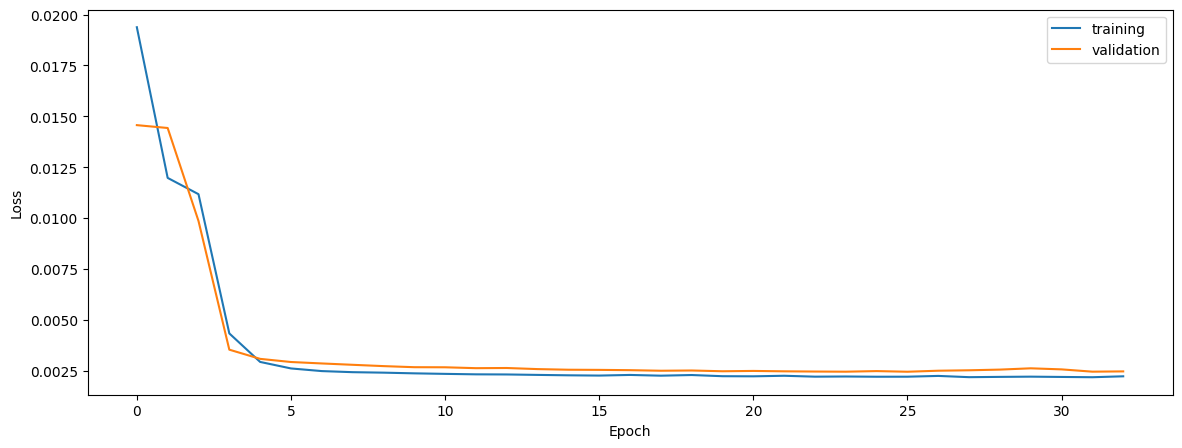

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


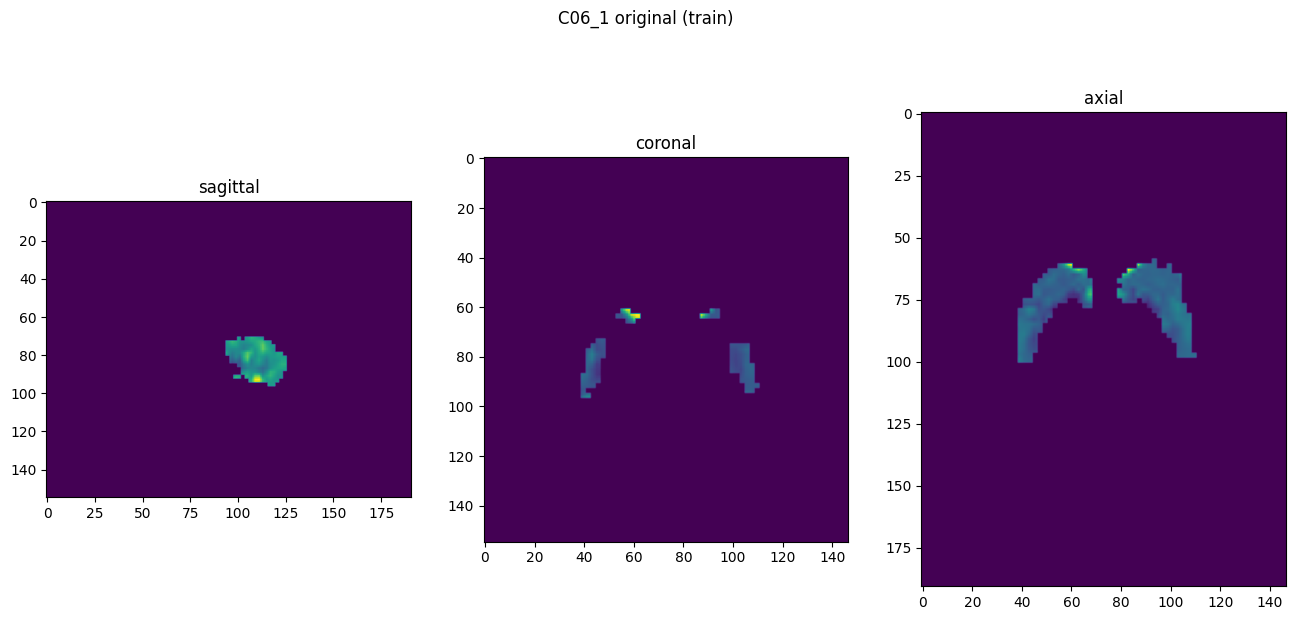

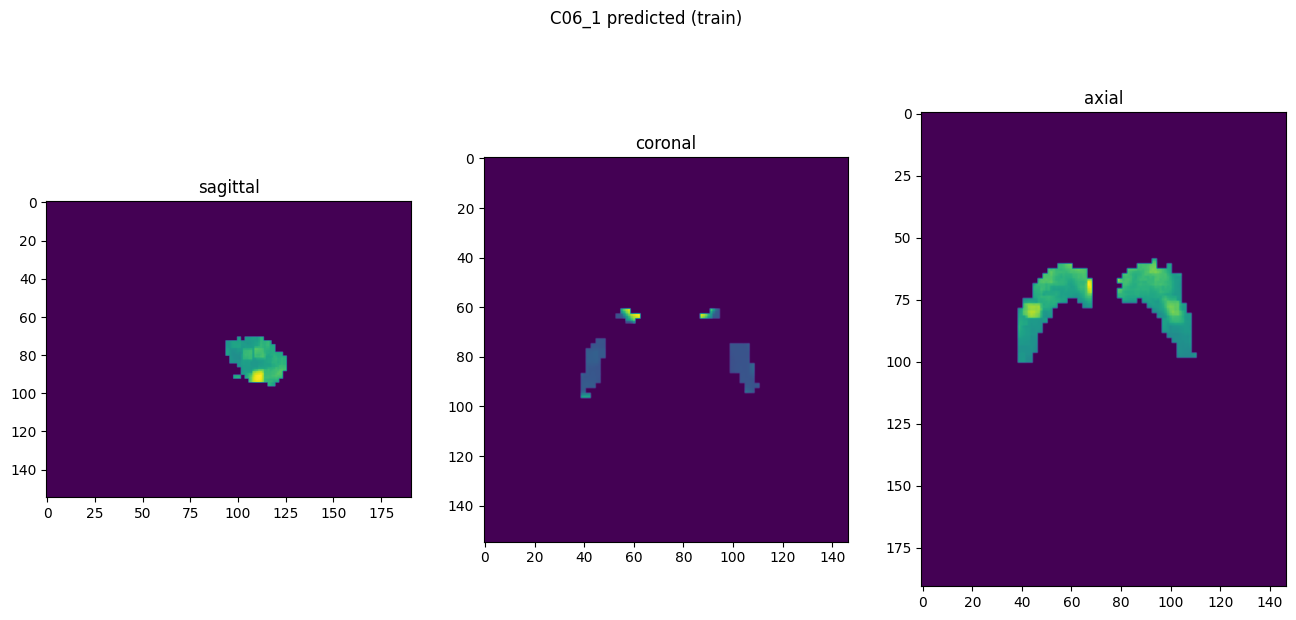

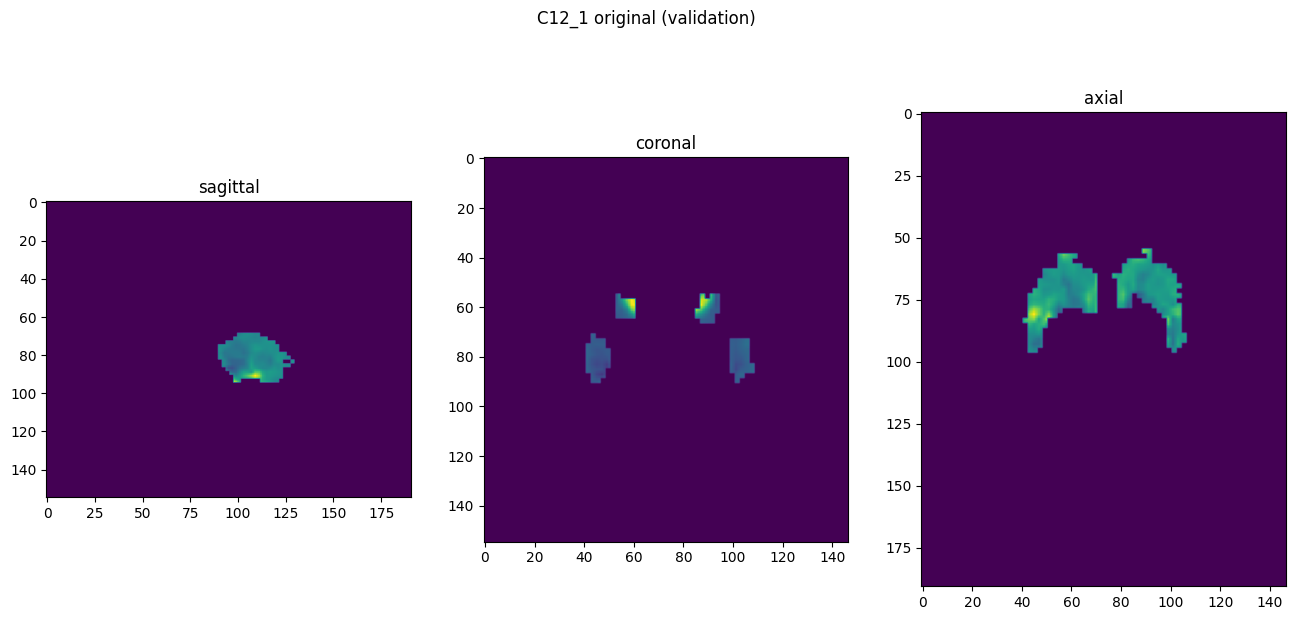

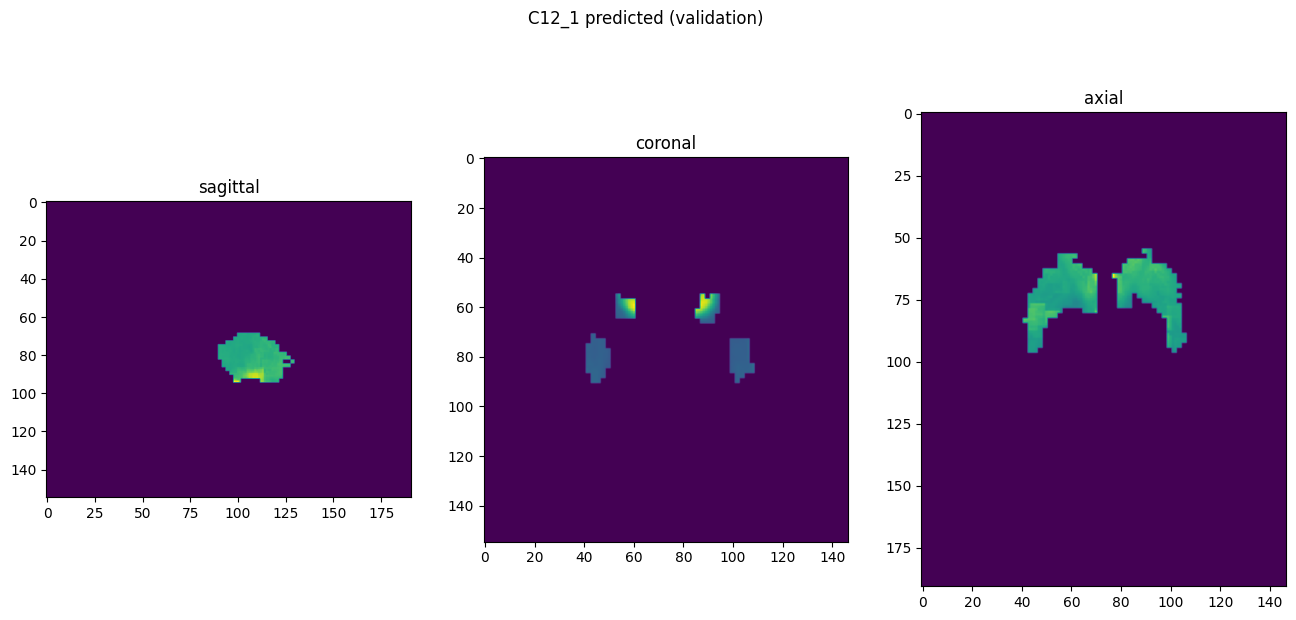

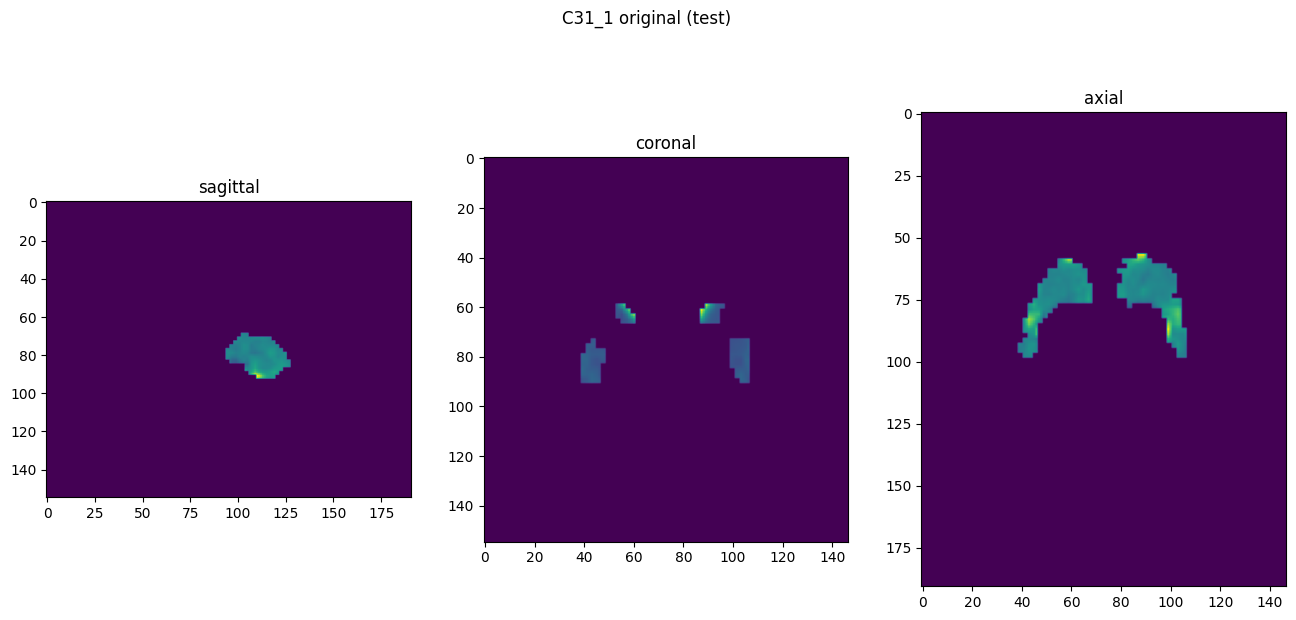

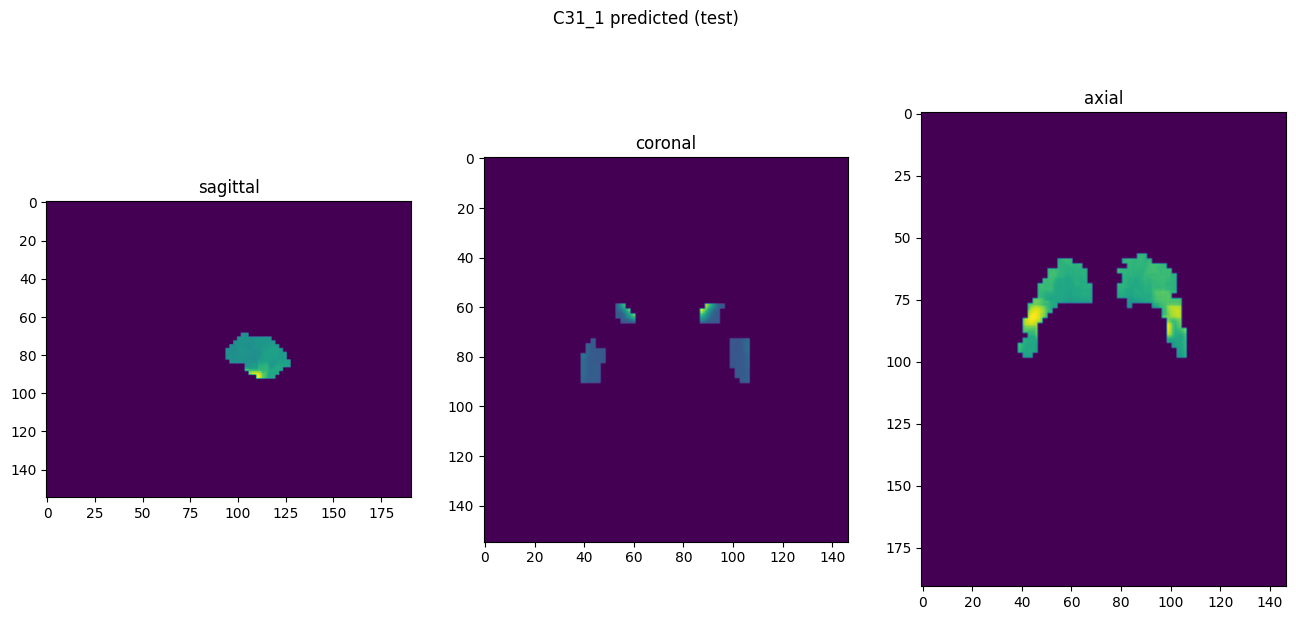

In [10]:
showResults(model, gen, threshold=None, background=False)